# 需要的一些库

In [1]:
import torch#深度学习的pytoch平台
import torch.nn as nn
import numpy as np
import random
import time#可以用来简单地记录时间
import matplotlib.pyplot as plt#画图
#随机种子
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

# 构建数据集（包括网络的输入以及对应的标签（真实值））

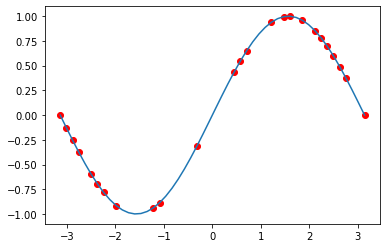

In [2]:
x = np.linspace(-np.pi,np.pi).astype(np.float32)
y = np.sin(x)
#随机取25个点
x_train = random.sample(x.tolist(),25)    #x_train 就相当于网络的输入
y_train = np.sin(x_train)                 #y_train 就相当于输入对应的标签，每一个输入都会对应一个标签
plt.scatter(x_train,y_train,c="r")
plt.plot(x,y)

# 搭建简单的全连接网络

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        layers =  [1,20,1]   #网络每一层的神经元个数，[1,10,1]说明只有一个隐含层，输入的变量是一个，也对应一个输出。如果是两个变量对应一个输出，那就是[2，10，1]
        self.layer1 = nn.Linear(layers[0],layers[1])  #用torh.nn.Linear构建线性层，本质上相当于构建了一个维度为[layers[0],layers[1]]的矩阵，这里面所有的元素都是权重
        self.layer2 = nn.Linear(layers[1],layers[2])
        self.elu = nn.ELU()       #非线性的激活函数。如果只有线性层，那么相当于输出只是输入做了了线性变换的结果，对于线性回归没有问题。但是非线性回归我们需要加入激活函数使输出的结果具有非线性的特征
    def forward(self,d):#d就是整个网络的输入
        d1 = self.layer1(d)
        d1 = self.elu(d1)#每一个线性层之后都需要加入一个激活函数使其非线性化。
        d2 = self.layer2(d1)#但是在网络的最后一层可以不用激活函数，因为有些激活函数会使得输出结果限定在一定的值域里。
        return d2


# 一些基本超参数的确定

In [4]:
device = torch.device("cuda") #在跑深度学习的时候最好使用GPU，这样速度会很快。不要的话默认用cpu跑
epochs = 10000                #这是迭代次数，把所有的训练数据输入到网络里去就叫完成了一次epoch。
learningrate = 1e-4           #学习率，相当于优化算法里的步长，学习率越大，网络参数更新地更加激进。学习率越小，网络学习地更加稳定。
net = DNN().to(device=device) #网络的初始化
optimizer = torch.optim.Adam(net.parameters(), lr=learningrate)#优化器，不同的优化器选择的优化方式不同，这里用的是随机梯度下降SGD的一种类型，Adam自适应优化器。需要输入网络的参数以及学习率，当然还可以设置其他的参数
mseloss  = nn.MSELoss()      #损失函数，这里选用的是MSE。损失函数也就是用来计算网络输出的结果与对应的标签之间的差距，差距越大，说明网络训练不够好，还需要继续迭代。
MinTrainLoss = 1e10          
train_loss =[]               #用一个空列表来存储训练时的损失，便于画图
pt_x_train = torch.from_numpy(np.array(x_train)).to(device=device,dtype = torch.float32).reshape(-1,1)  #这里需要把我们的训练数据转换为pytorch tensor的类型，并且把它变成gpu能运算的形式。
pt_y_train = torch.from_numpy(np.array(y_train)).to(device=device,dtype = torch.float32).reshape(-1,1) #reshap的目的是把维度变成(25,1),这样25相当于是batch，我们就可以一次性把所有的点都输入到网络里去，最后网络输出的结果也不是(1,1)而是(25,1)，我们就能直接计算所有点的损失
print(pt_x_train.dtype)
print(pt_x_train.shape)

torch.float32
torch.Size([25, 1])


# 网络训练过程

In [5]:
start = time.time()
start0=time.time()
for epoch in range(1,epochs+1):
    net.train()    #net.train()：在这个模式下，网络的参数会得到更新。对应的还有net.eval()，这就是在验证集上的时候，我们只评价模型，并不对网络参数进行更新。
    pt_y_pred = net(pt_x_train) #将tensor放入网络中得到预测值
    loss = mseloss(pt_y_pred,pt_y_train)  #用mseloss计算预测值和对应标签的差别
    optimizer.zero_grad()      #在每一次迭代梯度反传更新网络参数时，需要把之前的梯度清0，不然上一次的梯度会累积到这一次。
    loss.backward()  # 反向传播
    optimizer.step() #优化器进行下一次迭代
    if epoch % 10 == 0:#每10个epoch保存一次loss
        end = time.time()
        print("epoch:[%5d/%5d] time:%.2fs current_loss:%.5f"
          %(epoch,epochs,(end-start),loss.item()))
        start = time.time()
    train_loss.append(loss.item())
    if train_loss[-1] < MinTrainLoss:
        torch.save(net.state_dict(),"model.pth") #保存每一次loss下降的模型
        MinTrainLoss = train_loss[-1]
end0 = time.time()
print("训练总用时: %.2fmin"%((end0-start0)/60)) 

epoch:[   10/10000] time:0.03s current_loss:0.23093
epoch:[   20/10000] time:0.02s current_loss:0.22312
epoch:[   30/10000] time:0.03s current_loss:0.21624
epoch:[   40/10000] time:0.03s current_loss:0.21028
epoch:[   50/10000] time:0.03s current_loss:0.20520
epoch:[   60/10000] time:0.03s current_loss:0.20090
epoch:[   70/10000] time:0.03s current_loss:0.19730
epoch:[   80/10000] time:0.03s current_loss:0.19430
epoch:[   90/10000] time:0.03s current_loss:0.19180
epoch:[  100/10000] time:0.03s current_loss:0.18972
epoch:[  110/10000] time:0.03s current_loss:0.18799
epoch:[  120/10000] time:0.03s current_loss:0.18654
epoch:[  130/10000] time:0.03s current_loss:0.18533
epoch:[  140/10000] time:0.03s current_loss:0.18431
epoch:[  150/10000] time:0.03s current_loss:0.18345
epoch:[  160/10000] time:0.03s current_loss:0.18272
epoch:[  170/10000] time:0.03s current_loss:0.18209
epoch:[  180/10000] time:0.03s current_loss:0.18156
epoch:[  190/10000] time:0.03s current_loss:0.18110
epoch:[  200

epoch:[ 1600/10000] time:0.03s current_loss:0.15832
epoch:[ 1610/10000] time:0.03s current_loss:0.15810
epoch:[ 1620/10000] time:0.03s current_loss:0.15787
epoch:[ 1630/10000] time:0.03s current_loss:0.15765
epoch:[ 1640/10000] time:0.03s current_loss:0.15742
epoch:[ 1650/10000] time:0.03s current_loss:0.15720
epoch:[ 1660/10000] time:0.03s current_loss:0.15697
epoch:[ 1670/10000] time:0.03s current_loss:0.15674
epoch:[ 1680/10000] time:0.03s current_loss:0.15651
epoch:[ 1690/10000] time:0.03s current_loss:0.15628
epoch:[ 1700/10000] time:0.03s current_loss:0.15604
epoch:[ 1710/10000] time:0.03s current_loss:0.15581
epoch:[ 1720/10000] time:0.03s current_loss:0.15557
epoch:[ 1730/10000] time:0.03s current_loss:0.15534
epoch:[ 1740/10000] time:0.03s current_loss:0.15510
epoch:[ 1750/10000] time:0.03s current_loss:0.15486
epoch:[ 1760/10000] time:0.03s current_loss:0.15462
epoch:[ 1770/10000] time:0.03s current_loss:0.15438
epoch:[ 1780/10000] time:0.03s current_loss:0.15414
epoch:[ 1790

epoch:[ 3200/10000] time:0.03s current_loss:0.10817
epoch:[ 3210/10000] time:0.03s current_loss:0.10778
epoch:[ 3220/10000] time:0.03s current_loss:0.10739
epoch:[ 3230/10000] time:0.03s current_loss:0.10700
epoch:[ 3240/10000] time:0.03s current_loss:0.10661
epoch:[ 3250/10000] time:0.03s current_loss:0.10621
epoch:[ 3260/10000] time:0.03s current_loss:0.10582
epoch:[ 3270/10000] time:0.03s current_loss:0.10543
epoch:[ 3280/10000] time:0.03s current_loss:0.10503
epoch:[ 3290/10000] time:0.03s current_loss:0.10464
epoch:[ 3300/10000] time:0.03s current_loss:0.10424
epoch:[ 3310/10000] time:0.03s current_loss:0.10385
epoch:[ 3320/10000] time:0.03s current_loss:0.10345
epoch:[ 3330/10000] time:0.03s current_loss:0.10305
epoch:[ 3340/10000] time:0.03s current_loss:0.10266
epoch:[ 3350/10000] time:0.03s current_loss:0.10226
epoch:[ 3360/10000] time:0.03s current_loss:0.10186
epoch:[ 3370/10000] time:0.03s current_loss:0.10146
epoch:[ 3380/10000] time:0.03s current_loss:0.10107
epoch:[ 3390

epoch:[ 4780/10000] time:0.03s current_loss:0.04711
epoch:[ 4790/10000] time:0.03s current_loss:0.04677
epoch:[ 4800/10000] time:0.03s current_loss:0.04644
epoch:[ 4810/10000] time:0.03s current_loss:0.04611
epoch:[ 4820/10000] time:0.03s current_loss:0.04578
epoch:[ 4830/10000] time:0.03s current_loss:0.04545
epoch:[ 4840/10000] time:0.03s current_loss:0.04512
epoch:[ 4850/10000] time:0.03s current_loss:0.04480
epoch:[ 4860/10000] time:0.03s current_loss:0.04447
epoch:[ 4870/10000] time:0.03s current_loss:0.04415
epoch:[ 4880/10000] time:0.03s current_loss:0.04383
epoch:[ 4890/10000] time:0.03s current_loss:0.04351
epoch:[ 4900/10000] time:0.03s current_loss:0.04319
epoch:[ 4910/10000] time:0.04s current_loss:0.04287
epoch:[ 4920/10000] time:0.03s current_loss:0.04255
epoch:[ 4930/10000] time:0.03s current_loss:0.04223
epoch:[ 4940/10000] time:0.03s current_loss:0.04192
epoch:[ 4950/10000] time:0.03s current_loss:0.04161
epoch:[ 4960/10000] time:0.07s current_loss:0.04129
epoch:[ 4970

epoch:[ 6360/10000] time:0.06s current_loss:0.01282
epoch:[ 6370/10000] time:0.05s current_loss:0.01272
epoch:[ 6380/10000] time:0.03s current_loss:0.01262
epoch:[ 6390/10000] time:0.06s current_loss:0.01253
epoch:[ 6400/10000] time:0.03s current_loss:0.01243
epoch:[ 6410/10000] time:0.03s current_loss:0.01234
epoch:[ 6420/10000] time:0.03s current_loss:0.01225
epoch:[ 6430/10000] time:0.03s current_loss:0.01216
epoch:[ 6440/10000] time:0.09s current_loss:0.01206
epoch:[ 6450/10000] time:0.03s current_loss:0.01198
epoch:[ 6460/10000] time:0.03s current_loss:0.01189
epoch:[ 6470/10000] time:0.04s current_loss:0.01180
epoch:[ 6480/10000] time:0.03s current_loss:0.01171
epoch:[ 6490/10000] time:0.05s current_loss:0.01163
epoch:[ 6500/10000] time:0.03s current_loss:0.01154
epoch:[ 6510/10000] time:0.03s current_loss:0.01146
epoch:[ 6520/10000] time:0.04s current_loss:0.01138
epoch:[ 6530/10000] time:0.05s current_loss:0.01130
epoch:[ 6540/10000] time:0.05s current_loss:0.01121
epoch:[ 6550

epoch:[ 7970/10000] time:0.06s current_loss:0.00484
epoch:[ 7980/10000] time:0.03s current_loss:0.00481
epoch:[ 7990/10000] time:0.03s current_loss:0.00479
epoch:[ 8000/10000] time:0.03s current_loss:0.00476
epoch:[ 8010/10000] time:0.05s current_loss:0.00473
epoch:[ 8020/10000] time:0.03s current_loss:0.00471
epoch:[ 8030/10000] time:0.05s current_loss:0.00468
epoch:[ 8040/10000] time:0.03s current_loss:0.00466
epoch:[ 8050/10000] time:0.03s current_loss:0.00463
epoch:[ 8060/10000] time:0.03s current_loss:0.00460
epoch:[ 8070/10000] time:0.06s current_loss:0.00458
epoch:[ 8080/10000] time:0.03s current_loss:0.00455
epoch:[ 8090/10000] time:0.03s current_loss:0.00452
epoch:[ 8100/10000] time:0.03s current_loss:0.00450
epoch:[ 8110/10000] time:0.03s current_loss:0.00447
epoch:[ 8120/10000] time:0.07s current_loss:0.00445
epoch:[ 8130/10000] time:0.08s current_loss:0.00442
epoch:[ 8140/10000] time:0.07s current_loss:0.00440
epoch:[ 8150/10000] time:0.06s current_loss:0.00437
epoch:[ 8160

epoch:[ 9610/10000] time:0.03s current_loss:0.00144
epoch:[ 9620/10000] time:0.03s current_loss:0.00142
epoch:[ 9630/10000] time:0.03s current_loss:0.00141
epoch:[ 9640/10000] time:0.03s current_loss:0.00140
epoch:[ 9650/10000] time:0.03s current_loss:0.00138
epoch:[ 9660/10000] time:0.03s current_loss:0.00137
epoch:[ 9670/10000] time:0.03s current_loss:0.00135
epoch:[ 9680/10000] time:0.03s current_loss:0.00134
epoch:[ 9690/10000] time:0.04s current_loss:0.00133
epoch:[ 9700/10000] time:0.03s current_loss:0.00131
epoch:[ 9710/10000] time:0.12s current_loss:0.00130
epoch:[ 9720/10000] time:0.03s current_loss:0.00129
epoch:[ 9730/10000] time:0.03s current_loss:0.00127
epoch:[ 9740/10000] time:0.03s current_loss:0.00126
epoch:[ 9750/10000] time:0.03s current_loss:0.00125
epoch:[ 9760/10000] time:0.03s current_loss:0.00124
epoch:[ 9770/10000] time:0.03s current_loss:0.00122
epoch:[ 9780/10000] time:0.03s current_loss:0.00121
epoch:[ 9790/10000] time:0.03s current_loss:0.00120
epoch:[ 9800

# 查看损失函数

Text(0, 0.5, 'loss')

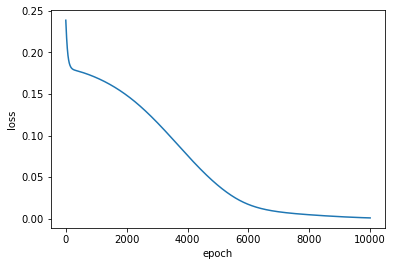

In [6]:
plt.plot(range(epochs),train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")

# 导入网络模型，预测结果

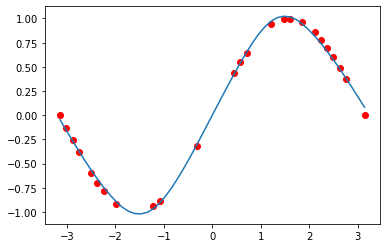

In [7]:
x_test = np.linspace(-np.pi,np.pi).astype(np.float32)
pt_x_test = torch.from_numpy(x_test).to(device=device,dtype=torch.float32).reshape(-1,1)
Dnn = DNN().to(device)
Dnn.load_state_dict(torch.load("model.pth",map_location=device))#pytoch 导入模型
Dnn.eval()#这里指评价模型，不反传，所以用eval模式
pt_y_test = Dnn(pt_x_test) 
y_test = pt_y_test.detach().cpu().numpy()#输出结果torch tensor，需要转化为numpy类型来进行可视化
plt.scatter(x_train,y_train,c="r")
plt.plot(x_test,y_test)